In [273]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from numpy import genfromtxt
from scipy import stats

In [274]:
# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    # 아래꺼 np.c_만 하면 되는거 아닌가? reshape는 왜하지
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [275]:
def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', header=None)
    return df

def merge_column(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[1]/2):
        new_df[i] = df[i] * df[i+1]
    return new_df

In [276]:
df = read_data('poker-hand-training-true.data')
df_test = read_data('poker-hand-testing.data')
print(df.tail())
print(df_test.tail())

       0   1   2   3   4   5   6   7   8   9   10
25005   3   9   2   6   4  11   4  12   2   4   0
25006   4   1   4  10   3  13   3   4   1  10   1
25007   2   1   2  10   4   4   4   1   4  13   1
25008   2  12   4   3   1  10   1  12   4   9   1
25009   1   7   3  11   3   3   4   8   3   7   1
        0   1   2   3   4   5   6   7   8   9   10
999995   3   1   1  12   2   9   4   9   2   6   1
999996   3   3   4   5   2   7   1   4   4   3   1
999997   1  11   4   7   3   9   1  13   2   7   1
999998   3  11   1   8   1   1   3  13   2   8   1
999999   2   5   2   9   4   9   2   3   3   3   2


In [277]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1:].values
print(stats.describe(features).variance)
print(features.shape, labels.shape)

features_test = df_test.iloc[:, :-1].values
labels_test = df_test.iloc[:, -1:].values

[  1.24653454  14.06103538   1.25836179  14.19009001   1.26146106
  14.02483064   1.24547499  14.04111337   1.25156226  13.99941097]
(25010, 10) (25010, 1)


In [278]:
features = feature_normalize(features)
print(stats.describe(features).variance)

features_test = feature_normalize(features_test)
print(stats.describe(features_test).variance)

[ 1.00003999  1.00003999  1.00003999  1.00003999  1.00003999  1.00003999
  1.00003999  1.00003999  1.00003999  1.00003999]
[ 1.000001  1.000001  1.000001  1.000001  1.000001  1.000001  1.000001
  1.000001  1.000001  1.000001]


In [279]:
train_x = features
train_y = labels
test_x = features_test
test_y = labels_test

feature_count = train_x.shape[1]
label_count = train_y.shape[1]
print(feature_count, label_count)

10 1


In [280]:
training_epochs = 50000
learning_rate = 0.1
cost_history = np.empty(shape=[1],dtype=float)
nb_classes = 10

# x는 float32 로 할 필요가 있나? normalized 되었기때문에 float32 써야함
X = tf.placeholder(tf.float32,[None,feature_count])
Y = tf.placeholder(tf.int32,[None,label_count])
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

one_hot Tensor("one_hot_20:0", shape=(?, 1, 10), dtype=float32)
reshape Tensor("Reshape_80:0", shape=(?, 10), dtype=float32)


In [281]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.1))

def model(X, p_keep_input, p_keep_hidden): # this network is the same as the previous one except with an extra hidden layer + dropout
    s_1 = feature_count + 4
    s_2 = feature_count + 4
    s_3 = feature_count
    s_4 = feature_count
    s_5 = feature_count
    
    w_h = init_weights([feature_count, s_1])
    w_h2 = init_weights([s_1, s_2])
#     w_h3 = init_weights([s_2, s_3])
#     w_h4 = init_weights([s_3, s_4])
    w_o = init_weights([s_2, nb_classes])
    
    b = tf.Variable(tf.random_normal([s_1]))
    b2 = tf.Variable(tf.random_normal([s_2]))
#     b3 = tf.Variable(tf.random_normal([s_3]))
    b_o = tf.Variable(tf.random_normal([nb_classes]))
    
    X = tf.nn.dropout(X, p_keep_input)
    h = tf.nn.relu(tf.matmul(X, w_h) + b)
    h = tf.nn.dropout(h, p_keep_hidden)
    h2 = tf.nn.relu(tf.matmul(h, w_h2) + b2)
    h2 = tf.nn.dropout(h2, p_keep_hidden)
#     h3 = tf.nn.relu(tf.matmul(h2, w_h3) + b3)
#     h3 = tf.nn.dropout(h3, p_keep_hidden)
    
#     b4 = tf.Variable(tf.random_normal([s_4]))
#     h4 = tf.nn.softmax(tf.matmul(h3, w_h4) + b4)
    
#     h4 = tf.nn.dropout(h4, p_keep_hidden)
#     b5 = tf.Variable(tf.random_normal([s_5]))
#     w_h5 = init_weights([s_4, s_5])
#     h5 = tf.nn.softmax(tf.matmul(h4, w_h5) + b5)
    
# #     h5 = tf.nn.dropout(h5, p_keep_hidden)
#     b6 = tf.Variable(tf.random_normal([feature_count]))
#     w_h6 = init_weights([feature_count, feature_count])
#     h6 = tf.nn.relu(tf.matmul(h5, w_h6) + b6)
    
# #     h6 = tf.nn.dropout(h4, p_keep_hidden)
#     b7 = tf.Variable(tf.random_normal([feature_count]))
#     w_h7 = init_weights([feature_count, feature_count])
#     h7 = tf.nn.relu(tf.matmul(h6, w_h7) + b7)
    
# #     h7 = tf.nn.dropout(h7, p_keep_hidden)
#     b8 = tf.Variable(tf.random_normal([feature_count]))
#     w_h8 = init_weights([feature_count, feature_count])
#     h8 = tf.nn.relu(tf.matmul(h7, w_h8) + b8)
    
# #     h8 = tf.nn.dropout(h8, p_keep_hidden)
#     b9 = tf.Variable(tf.random_normal([feature_count]))
#     w_h9 = init_weights([feature_count, feature_count])
#     h9 = tf.nn.relu(tf.matmul(h8, w_h9) + b9)
    
# #     h9 = tf.nn.dropout(h9, p_keep_hidden)
#     b10 = tf.Variable(tf.random_normal([feature_count]))
#     w_h10 = init_weights([feature_count, feature_count])
#     h10 = tf.nn.relu(tf.matmul(h9, w_h10) + b10)
    
#     h10 = tf.nn.dropout(h10, p_keep_hidden)

    
    
    return tf.matmul(h2, w_o) + b_o

In [282]:
# w0, b0, h0 = get_class_logits()

p_keep_input = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

h0 = model(X, p_keep_input, p_keep_hidden)

In [283]:
# https://github.com/carpedm20/DCGAN-tensorflow/issues/99
# all_logits = tf.concat([h0, h1, h2], 1)

# regularizers = tf.nn.l2_loss(w0)

# Cross entropy cost/loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h0, labels=Y_one_hot))
# + 1e-4*regularizers
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [284]:
prediction = tf.argmax(h0, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [285]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(X.shape, Y.shape)
training_dropout_i = 1.0
training_dropout_h = 1.0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        cost_history = np.append(cost_history, acc)
        if step % 1000 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    pre = tf.argmax(h0, 1)
    test_yy = np.transpose(test_y.ravel())
    print(test_yy.shape)
    correct_prediction = tf.equal(pre, test_yy)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test Accuracy:', sess.run(accuracy, feed_dict={X: test_x, 
                                                         p_keep_input: 1.0,
                                                         p_keep_hidden: 1.0}))

(25010, 10) (25010, 1)
(1000000, 10) (1000000, 1)
(?, 10) (?, 1)
Step:     0	Loss: 1.564	Acc: 42.38%
Step:  1000	Loss: 0.872	Acc: 58.71%
Step:  2000	Loss: 0.879	Acc: 59.62%
Step:  3000	Loss: 0.901	Acc: 58.41%
Step:  4000	Loss: 0.880	Acc: 58.94%
Step:  5000	Loss: 0.877	Acc: 58.98%
Step:  6000	Loss: 0.886	Acc: 58.00%
Step:  7000	Loss: 0.871	Acc: 60.89%
Step:  8000	Loss: 0.868	Acc: 60.86%
Step:  9000	Loss: 0.870	Acc: 60.34%
Step: 10000	Loss: 0.866	Acc: 60.75%
Step: 11000	Loss: 0.872	Acc: 60.22%
Step: 12000	Loss: 0.849	Acc: 61.70%
Step: 13000	Loss: 0.892	Acc: 59.33%
Step: 14000	Loss: 0.873	Acc: 60.30%
Step: 15000	Loss: 0.891	Acc: 57.28%
Step: 16000	Loss: 0.870	Acc: 60.93%
Step: 17000	Loss: 0.864	Acc: 60.28%
Step: 18000	Loss: 0.861	Acc: 60.77%
Step: 19000	Loss: 0.863	Acc: 61.22%
Step: 20000	Loss: 0.857	Acc: 61.60%
Step: 21000	Loss: 0.865	Acc: 60.54%
Step: 22000	Loss: 0.870	Acc: 61.10%
Step: 23000	Loss: 0.880	Acc: 60.99%
Step: 24000	Loss: 0.860	Acc: 61.05%
Step: 25000	Loss: 0.863	Acc: 61.30%

(50002,)


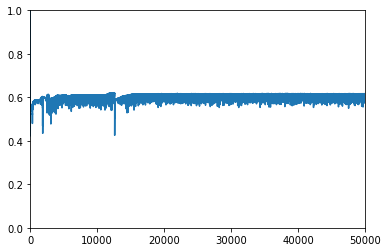

In [286]:
print(cost_history.shape)
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,1])
plt.show()

In [287]:
sess.close()